# Install/Import Packages

In [ ]:
!pip install sentence-transformers # For sentence embeddings
!pip install transformers # For transfer learning

In [11]:
from collections import defaultdict
import datetime
from google.colab import drive
import imblearn
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns; sns.set_style("ticks")
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import time
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, RandomSampler, SequentialSampler, TensorDataset 
from tqdm import tqdm; tqdm.pandas()
from transformers import AdamW, AutoModel, DistilBertTokenizerFast, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput
from wordcloud import WordCloud

# Data Preprocessing

The original dataset is review-level i.e. each row contains an entire review. We convert the dataset to sentence-level i.e one review sentence per row, and do some additional preprocessing.

In [ ]:
# Load original dataset
!gdown --id ########## Put ID here ##########

In [ ]:
df = pd.read_json(
    path_or_buf="/content/goodreads_reviews_spoiler.json", 
    lines=True
)
df.head(5)

In [ ]:
# review_id, user_id, and book_id are in string format. We convert them to a 
# numeric format for space saving.
df.review_id = LabelEncoder().fit_transform(df.review_id)
df.user_id = LabelEncoder().fit_transform(df.user_id)
df.book_id = LabelEncoder().fit_transform(df.book_id)

In [ ]:
# Convert dataset from review-level to sentence-level
cache = defaultdict(list)

for i in tqdm(range(len(df))):
    _pos_sentence, _num_sentences = 0, len(df.review_sentences.iloc[i])
    
    for is_spoiler, sentence in df.review_sentences.iloc[i]:
        cache["timestamp"].append(df.timestamp.iloc[i])
        cache["review_id"].append(df.review_id.iloc[i])
        cache["user_id"].append(df.user_id.iloc[i])
        cache["book_id"].append(df.book_id.iloc[i])
        cache["review_rating"].append(df.rating.iloc[i])
        cache["is_spoiler"].append(is_spoiler)
        cache["sentence"].append(str(sentence))
        cache["_pos_sentence"].append(_pos_sentence)
        _pos_sentence += 1
        cache["_num_sentences"].append(_num_sentences)

# Save sentence-level dataset
drive.mount('drive')
pd.DataFrame(data=cache).to_csv("data.csv")
!cp data.csv "drive/My Drive/"

In [ ]:
# Load sentence-level dataset
!gdown ########## Put ID here ##########

In [ ]:
df = pd.read_csv(filepath_or_buffer="/content/data.csv")
df.head(5)

In [ ]:
# Drop unnamed column
df.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
# Drop rows with missing values
print(df.isnull().sum())
df.dropna(inplace=True)

In [ ]:
# Drop sentences that have been marked as both spoilers and not-spoilers
spoiler_sentences = set(df.sentence[df.is_spoiler == 1])
not_spoiler_sentences = set(df.sentence[df.is_spoiler == 0])

df["flag"] = df.sentence.apply(
    lambda s: not ((s in spoiler_sentences) and (s in not_spoiler_sentences))
)
df = df[df.flag]

df.drop(columns=["flag"], inplace=True)

In [ ]:
# Truncate dataset to reduce computational/storage requirements
# Use random sampling to preserve class distributions
df_trunc = df.sample(n=199000, random_state=42, ignore_index=True)

In [ ]:
# Create pretrained sentence embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentence_transformer = SentenceTransformer(
    model_name_or_path="all-MiniLM-L6-v2", device=device
)
embeddings = sentence_transformer.encode(
    sentences=df_trunc.sentence.values, 
    show_progress_bar=True, 
    convert_to_numpy=True, 
    device=device
)
df_trunc["sentence_embedding"] = pd.Series(list(embeddings))

In [ ]:
# Split dataset into train/val/test datasets
X_train, X_test_, y_train, y_test_ = train_test_split(
    df_trunc.loc[:, df_trunc.columns != "is_spoiler"], 
    df_trunc["is_spoiler"], 
    train_size=99000, 
    test_size=100000, 
    random_state=42, 
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_, 
    y_test_, 
    train_size=50000, 
    test_size=50000, 
    random_state=42, 
    shuffle=True
)

# Save datasets
drive.mount("drive")
X_train.to_pickle("X_train.pkl")
!cp X_train.pkl "drive/My Drive/"
X_val.to_pickle("X_val.pkl")
!cp X_val.pkl "drive/My Drive/"
X_test.to_pickle("X_test.pkl")
!cp X_test.pkl "drive/My Drive/"
y_train.to_pickle("y_train.pkl")
!cp y_train.pkl "drive/My Drive/"
y_val.to_pickle("y_val.pkl")
!cp y_val.pkl "drive/My Drive/"
y_test.to_pickle("y_test.pkl")
!cp y_test.pkl "drive/My Drive/"

# Load Train/Val/Test Datasets & Data Setup

In [ ]:
# Load train/val/test datasets
!gdown ########## Put ID here ########## # X_train
!gdown ########## Put ID here ########## # X_val
!gdown ########## Put ID here ########## # X_test
!gdown ########## Put ID here ########## # y_train
!gdown ########## Put ID here ########## # y_val
!gdown ########## Put ID here ########## # y_test

In [4]:
X_train = pd.read_pickle(filepath_or_buffer="/content/X_train.pkl")
y_train = pd.read_pickle(filepath_or_buffer="/content/y_train.pkl")
X_val = pd.read_pickle(filepath_or_buffer="/content/X_val.pkl")
y_val = pd.read_pickle(filepath_or_buffer="/content/y_val.pkl")
X_test = pd.read_pickle(filepath_or_buffer="/content/X_test.pkl")
y_test = pd.read_pickle(filepath_or_buffer="/content/y_test.pkl")

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

In [6]:
# Feature Engineering

# Relative position of the sentence in the review
X_train["_rel_pos_sentence"] = X_train._pos_sentence / X_train._num_sentences
X_val["_rel_pos_sentence"] = X_val._pos_sentence / X_val._num_sentences
X_test["_rel_pos_sentence"] = X_test._pos_sentence / X_test._num_sentences

# No. of characters in the sentence
X_train["_len_sentence"] = X_train.sentence.apply(lambda s: len(s))
X_val["_len_sentence"] = X_val.sentence.apply(lambda s: len(s))
X_test["_len_sentence"] = X_test.sentence.apply(lambda s: len(s))

# Log of the no. of characters in the sentence
X_train["_len_sentence_log"] = X_train._len_sentence.apply(lambda x: np.log(x))
X_val["_len_sentence_log"] = X_val._len_sentence.apply(lambda x: np.log(x))
X_test["_len_sentence_log"] = X_test._len_sentence.apply(lambda x: np.log(x))

In [7]:
# Create feature array of sentence embeddings, relative positions of sentences, 
# and logs of lengths of sentences; To be used for logistic regression, MPC, 
# and RFC

X_train_sentence_embedding = np.array(X_train.sentence_embedding.tolist())
X_val_sentence_embedding = np.array(X_val.sentence_embedding.tolist())
X_test_sentence_embedding = np.array(X_test.sentence_embedding.tolist())

X_train_values = np.hstack(
    tup=(
        np.array(X_train.sentence_embedding.tolist()), 
        np.expand_dims(X_train._rel_pos_sentence.values, axis=1),
        np.expand_dims(X_train._len_sentence_log.values, axis=1),
    )
)

X_val_values = np.hstack(
    tup=(
        np.array(X_val.sentence_embedding.tolist()), 
        np.expand_dims(X_val._rel_pos_sentence.values, axis=1),
        np.expand_dims(X_val._len_sentence_log.values, axis=1),
    )
)

X_test_values = np.hstack(
    tup=(
        np.array(X_test.sentence_embedding.tolist()), 
        np.expand_dims(X_test._rel_pos_sentence.values, axis=1),
        np.expand_dims(X_test._len_sentence_log.values, axis=1),
    )
)

y_train_values = y_train.values.ravel()
y_val_values = y_val.values.ravel()
y_test_values = y_test.values.ravel()

# Data Exploration

Please refer to the Data Set section of the final report for an explanation of the data exploration.

In [8]:
df = pd.concat(
    [
        pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True), 
        pd.concat([y_train, y_val, y_test], axis=0, ignore_index=True)
    ], axis=1
)

No. of reviews              : 172,004
No. of users                : 15,605
No. of books                : 23,450
No. of sentences            : 199,000
% of sentences with spoilers: 3.16%



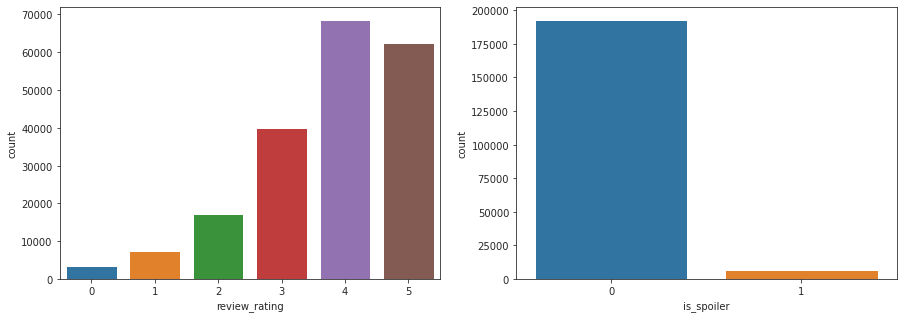

In [9]:
print(f"No. of reviews              : {df.review_id.nunique():,}")
print(f"No. of users                : {df.user_id.nunique():,}")
print(f"No. of books                : {df.book_id.nunique():,}")
print(f"No. of sentences            : {len(df):,}")
print(f"% of sentences with spoilers: {round(df.is_spoiler.sum() * 100 / len(df), 2)}%\n")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df.review_rating, ax=ax[0])
sns.countplot(x=df.is_spoiler, ax=ax[1])
fig.show()

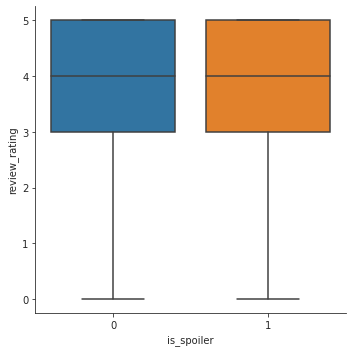

In [10]:
# is_spoiler vs. review_rating
sns.catplot(data=df, x="is_spoiler", y="review_rating", kind="box")

([], <a list of 0 Text major ticklabel objects>)

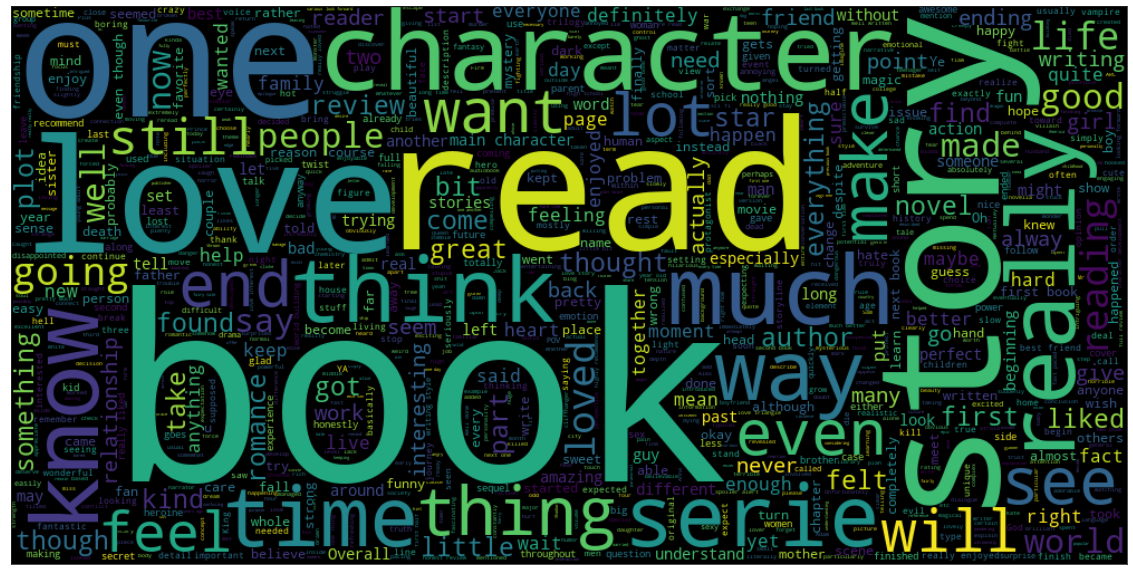

In [ ]:
# Not spoiler sentences wordcloud
wc = WordCloud(max_words=2000, width=1000, height=500)
wc.generate(" ".join(df[df.is_spoiler == 0]["sentence"]))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation="bilinear")
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

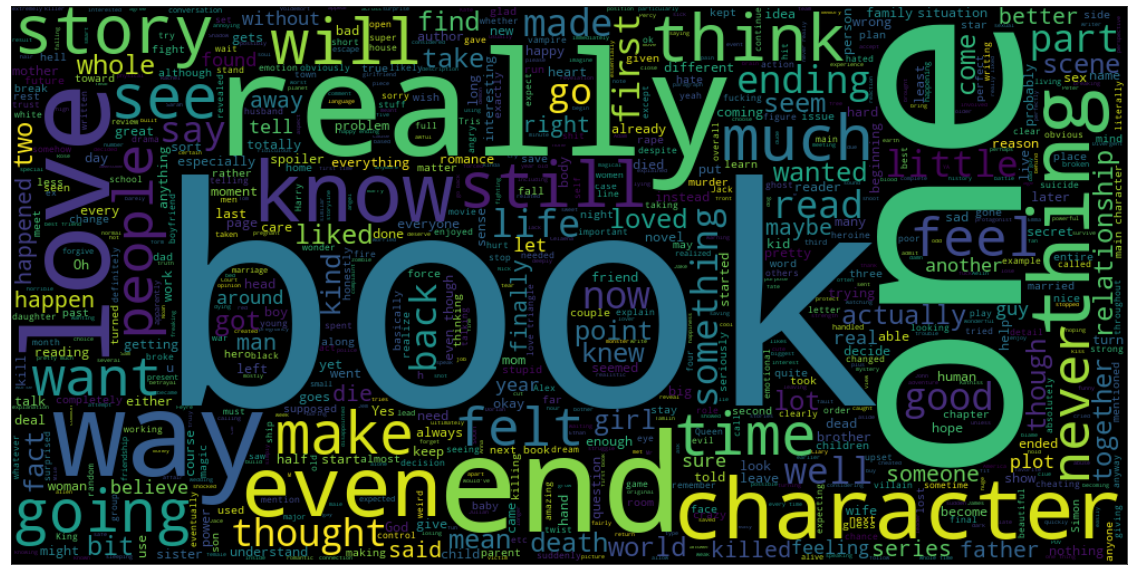

In [ ]:
# Spoiler sentences wordcloud
wc = WordCloud(max_words=2000, width=1000, height=500)
wc.generate(" ".join(df[df.is_spoiler == 1]["sentence"]))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation="bilinear")
plt.xticks([])
plt.yticks([])

<Figure size 720x360 with 0 Axes>

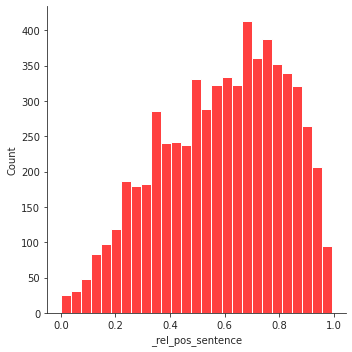

In [ ]:
# Relative positions of spoilers in reviews
plt.figure(figsize=(10, 5))

sns.displot(
    data=df[df.is_spoiler == 1], x="_rel_pos_sentence", kind="hist", color="red"
)

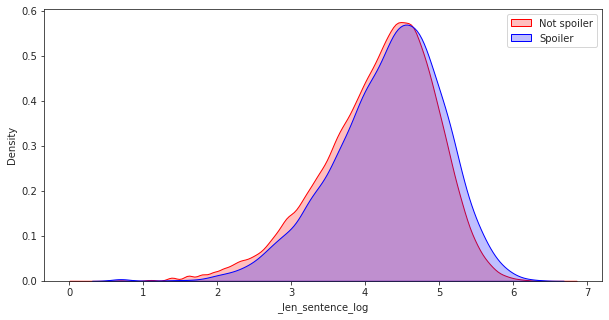

In [ ]:
# is_spoiler vs. log of length of sentence
plt.figure(figsize=(10, 5))

sns.kdeplot(
    data=df[df.is_spoiler == 0], 
    x="_len_sentence_log", 
    shade=True, 
    color="red", 
    label="Not spoiler", 
    clip=[0, 2000]
)
sns.kdeplot(
    data=df[df.is_spoiler == 1], 
    x="_len_sentence_log", 
    shade=True, 
    color="blue", 
    label="Spoiler", 
    clip=[0, 2000]
)

plt.legend(loc="best")

In [ ]:
X_TSNE = TSNE(
    n_components=2, random_state=42
).fit_transform(X_train_sentence_embedding[:10000])

fig = px.scatter(
    x=X_TSNE[:, 0].reshape(-1), 
    y=X_TSNE[:, 1].reshape(-1),
    color=y_train.values[:10000].reshape(-1), 
    labels={'color': 'label'},
    color_continuous_scale='Bluered_r'
)
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Utility Functions

We define some utility functions that are used during model training.

In [13]:
def print_metrics(model, X, y):
    """Prints performance metrics"""
    y_pred = model.predict(X) # Predicted labels
    y_pred_proba = model.predict_proba(X) # Predicted probabilities
    
    # Test accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y, y_pred=y_pred)}\n")
    
    # Classification report
    print(metrics.classification_report(y_true=y, y_pred=y_pred))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(
        xlabel="Pred", ylabel="True", 
        xticklabels=[0, 1], yticklabels=[0, 1], 
        title="Confusion Matrix"
    )

    # ROC curve/AUC score
    fpr, tpr, thresholds = metrics.roc_curve(
        y_true=y, y_score=y_pred_proba[:, 1], pos_label=1
    )
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    ax2.plot(
        fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})"
    )
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

In [14]:
def print_metrics_hyper(model, X, y):
    """Truncated version of print_metrics for hyperparameter tuning"""
    y_pred = clf.predict(X) # Predicted labels
    y_pred_proba = clf.predict_proba(X) # Predicted probabilities

    accuracy = metrics.accuracy_score(y_true=y, y_pred=y_pred)
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    precision, recall, fbeta_score, _ = metrics.precision_recall_fscore_support(
        y_true=y, y_pred=y_pred, average="binary"
    )
    print(f"accuracy: {accuracy:.3f}, auc: {auc_score:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, fbeta_score: {fbeta_score:.3f}")

In [15]:
def product_dict(**kwargs):
    """Helper function for hyperparameter tuning"""
    keys = kwargs.keys()
    vals = kwargs.values()
    return [dict(zip(keys, instance)) for instance in itertools.product(*vals)] 

# Baseline

In [ ]:
# Vectorize sentences
vectorizer = TfidfVectorizer(analyzer="word", max_features=20000)

X_train_sentence_tfidf = vectorizer.fit_transform(X_train.sentence.values)
X_val_sentence_tfidf = vectorizer.transform(X_val.sentence.values)
X_test_sentence_tfidf = vectorizer.transform(X_test.sentence.values)

In [ ]:
# Fit logistic regression model
clf = LogisticRegression(
    penalty="l2", random_state=42, solver="lbfgs", max_iter=1000, verbose=1
)
clf.fit(X_train_sentence_tfidf, y_train.is_spoiler.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished


LogisticRegression(max_iter=1000, random_state=42, verbose=1)

In [ ]:
# Print metrics on train dataset
print_metrics(clf, X_train_sentence_tfidf, y_train.is_spoiler.values)

In [ ]:
# Print metrics on val dataset
print_metrics(clf, X_val_sentence_tfidf, y_val.is_spoiler.values)

In [ ]:
# Print metrics on test dataset
print_metrics(clf, X_test_sentence_tfidf, y_test.is_spoiler.values)

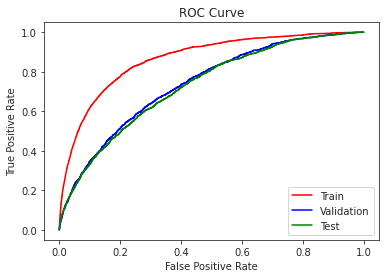

In [ ]:
# Combined ROC curve for train/val/test datasets

y_pred = clf.predict(X_train_sentence_tfidf)
y_pred_proba = clf.predict_proba(X_train_sentence_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_train.is_spoiler.values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_train.is_spoiler.values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="red", label=f"Train")

y_pred = clf.predict(X_val_sentence_tfidf)
y_pred_proba = clf.predict_proba(X_val_sentence_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_val.is_spoiler.values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_val.is_spoiler.values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="blue", label=f"Validation")

y_pred = clf.predict(X_test_sentence_tfidf)
y_pred_proba = clf.predict_proba(X_test_sentence_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test.is_spoiler.values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_test.is_spoiler.values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="green", label=f"Test")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")

# Logistic Regression

In [ ]:
# Underweight majority class + Hyperparameter tuning

class_weights = [{0: w, 1: 1} for w in [0.01, 0.05, 0.1, 0.3, 0.5, 1]]
params = (product_dict(**{"penalty": ["elasticnet"], "class_weight": class_weights, "l1_ratio": [0, 0.5, 1]}))

for param in params:
    penalty = param["penalty"]
    class_weight = param["class_weight"]
    l1_ratio = param["l1_ratio"]

    # Fit logistic regression model
    clf = LogisticRegression(penalty=penalty, class_weight=class_weight, random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    clf.fit(X_train_values, y_train_values)

    print(f"penalty: {penalty}, class_weight: {class_weight}, l1_ratio: {l1_ratio}")
    print_metrics_hyper(clf, X_train_values, y_train_values)
    print_metrics_hyper(clf, X_val_values, y_val_values)

In [ ]:
# Undersample majority class + Hyperparameter tuning

params = (product_dict(**{"sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1], "penalty": ["elasticnet"], "l1_ratio": [0, 0.5, 1]}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    penalty = param["penalty"]
    l1_ratio = param["l1_ratio"]

    # Undersample majority class
    X_train_rs_values, y_train_rs_values = imblearn.under_sampling.RandomUnderSampler(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)

    # Fit logistic regression model
    clf = LogisticRegression(penalty=penalty, random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, penalty: {penalty}, l1_ratio: {l1_ratio}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

In [ ]:
# Oversample minority class + Hyperparameter tuning

params = (product_dict(**{"sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1], "penalty": ["elasticnet"], "l1_ratio": [0, 0.5, 1]}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    penalty = param["penalty"]
    l1_ratio = param["l1_ratio"]

    # Oversample minority class
    X_train_rs_values, y_train_rs_values = imblearn.over_sampling.SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)

    # Fit logistic regression model
    clf = LogisticRegression(penalty=penalty, random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, penalty: {penalty}, l1_ratio: {l1_ratio}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

Best performing model

In [8]:
clf = LogisticRegression(penalty="elasticnet", class_weight={0: 0.1, 1: 1}, random_state=42, solver="saga", max_iter=1000, l1_ratio=0.5)
clf.fit(X_train_values, y_train_values)

LogisticRegression(class_weight={0: 0.1, 1: 1}, l1_ratio=0.5, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')

Accuracy: 0.917050505050505

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     95750
           1       0.16      0.35      0.21      3250

    accuracy                           0.92     99000
   macro avg       0.57      0.64      0.59     99000
weighted avg       0.95      0.92      0.93     99000



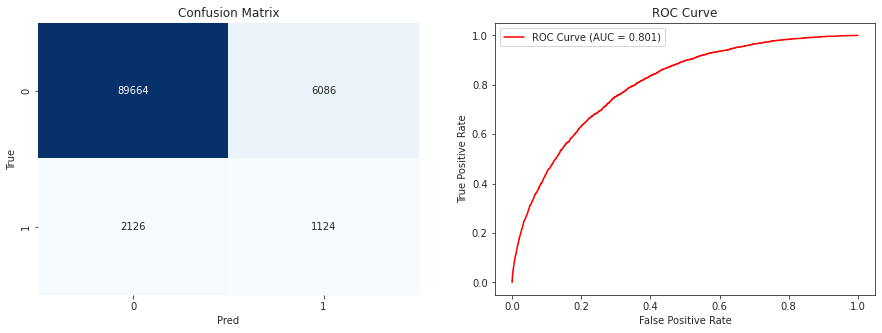

In [ ]:
# Print metrics on train dataset
print_metrics(clf, X_train_values, y_train_values)

Accuracy: 0.91702

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     48488
           1       0.14      0.34      0.20      1512

    accuracy                           0.92     50000
   macro avg       0.56      0.64      0.58     50000
weighted avg       0.95      0.92      0.93     50000



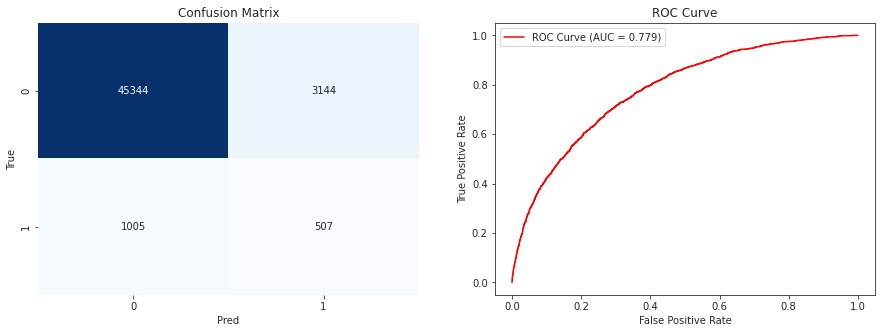

In [ ]:
# Print metrics on val dataset
print_metrics(clf, X_val_values, y_val_values)

Accuracy: 0.91756

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     48468
           1       0.14      0.32      0.19      1532

    accuracy                           0.92     50000
   macro avg       0.56      0.63      0.57     50000
weighted avg       0.95      0.92      0.93     50000



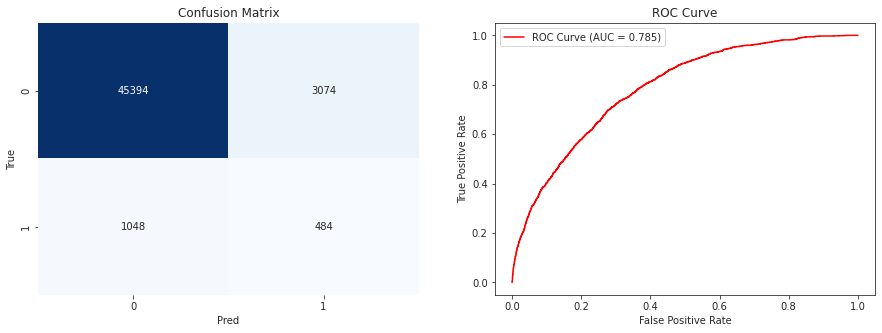

In [ ]:
# Print metrics on test dataset
print_metrics(clf, X_test_values, y_test_values)

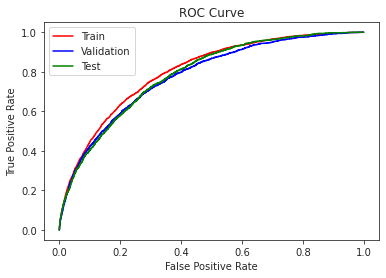

In [ ]:
# Combined ROC curve for train/val/test datasets

y_pred = clf.predict(X_train_values)
y_pred_proba = clf.predict_proba(X_train_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_train_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_train_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="red", label=f"Train")

y_pred = clf.predict(X_val_values)
y_pred_proba = clf.predict_proba(X_val_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_val_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_val_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="blue", label=f"Validation")

y_pred = clf.predict(X_test_values)
y_pred_proba = clf.predict_proba(X_test_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_test_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="green", label=f"Test")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")

# Multi-layer Perceptron Classifier

In [ ]:
params = (product_dict(**{
    'hidden_layer_sizes': [(128, 64, 32, 1)],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.05]
}))

for param in params:
    hidden_layer_sizes = param["hidden_layer_sizes"]
    activation = param["activation"]
    alpha = param["alpha"]

    # Fit model
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver="adam", alpha=alpha, random_state=42)
    clf.fit(X_train_values, y_train_values)

    print(f"hidden_layer_sizes: {hidden_layer_sizes}, activation: {activation}, alpha: {alpha}")
    print_metrics_hyper(clf, X_train_values, y_train_values)
    print_metrics_hyper(clf, X_val_values, y_val_values)

In [ ]:
# Undersample majority class + Hyperparameter tuning

params = (product_dict(**{
    "sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1],
    'hidden_layer_sizes': [(128, 64, 32, 1)],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.05]
}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    hidden_layer_sizes = param["hidden_layer_sizes"]
    activation = param["activation"]
    alpha = param["alpha"]

    # Undersample majority class
    X_train_rs_values, y_train_rs_values = imblearn.under_sampling.RandomUnderSampler(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)

    # Fit model
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver="adam", alpha=alpha, random_state=42)
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, hidden_layer_sizes: {hidden_layer_sizes}, activation: {activation}, alpha: {alpha}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

In [ ]:
# Oversample minority class + Hyperparameter tuning

params = (product_dict(**{
    "sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1],
    'hidden_layer_sizes': [(128, 64, 32, 1)],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.05]
}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    hidden_layer_sizes = param["hidden_layer_sizes"]
    activation = param["activation"]
    alpha = param["alpha"]

    # Oversample minority class
    X_train_rs_values, y_train_rs_values = imblearn.over_sampling.SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)

    # Fit model
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver="adam", alpha=alpha, random_state=42)
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, hidden_layer_sizes: {hidden_layer_sizes}, activation: {activation}, alpha: {alpha}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

Best performing model

In [ ]:
X_train_rs_values, y_train_rs_values = imblearn.over_sampling.SMOTE(
    sampling_strategy=0.3,
    random_state=42
).fit_resample(X_train_values, y_train_values)

clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 1), activation="tanh", solver="adam", alpha=0.05, random_state=42)
clf.fit(X_train_rs_values, y_train_rs_values)

In [ ]:
# Print metrics on train dataset
print_metrics(clf, X_train_values, y_train_values)

In [ ]:
# Print metrics on val dataset
print_metrics(clf, X_val_values, y_val_values)

In [ ]:
# Print metrics on test dataset
print_metrics(clf, X_test_values, y_test_values)

In [ ]:
# Combined ROC curve for train/val/test datasets

y_pred = clf.predict(X_train_values)
y_pred_proba = clf.predict_proba(X_train_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_train_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_train_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="red", label=f"Train")

y_pred = clf.predict(X_val_values)
y_pred_proba = clf.predict_proba(X_val_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_val_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_val_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="blue", label=f"Validation")

y_pred = clf.predict(X_test_values)
y_pred_proba = clf.predict_proba(X_test_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_test_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="green", label=f"Test")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")

# Random Forest Classifier

In [ ]:
# Underweight majority class + Hyperparameter tuning

params = (product_dict(**{
    "n_estimators": [100, 150],
    "max_depth": [5, 7],
    "min_samples_leaf": [1, 5],
    "class_weight": [{0: w, 1: 1} for w in [0.01, 0.05, 0.1, 0.3, 0.5, 1]]
}))

for param in params:
    n_estimators = param["n_estimators"]
    max_depth = param["max_depth"]
    min_samples_leaf = param["min_samples_leaf"]
    class_weight = param["class_weight"]
    
    # Fit model
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42, class_weight=class_weight)
    clf.fit(X_train_values, y_train_values)

    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, class_weight: {class_weight}")
    print_metrics_hyper(clf, X_train_values, y_train_values)
    print_metrics_hyper(clf, X_val_values, y_val_values)

In [ ]:
# Undersample majority class + Hyperparameter tuning

params = (product_dict(**{
    "n_estimators": [100, 150],
    "max_depth": [5, 7],
    "min_samples_leaf": [1, 5],
    "sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1]
}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    n_estimators = param["n_estimators"]
    max_depth = param["max_depth"]
    min_samples_leaf = param["min_samples_leaf"]
    
    # Undersample majority class
    X_train_rs_values, y_train_rs_values = imblearn.under_sampling.RandomUnderSampler(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)
    
    # Fit model
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

In [ ]:
# Oversample minority class + Hyperparameter tuning

params = (product_dict(**{
    "n_estimators": [100, 150],
    "max_depth": [5, 7],
    "min_samples_leaf": [1, 5],
    "sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1]
}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    n_estimators = param["n_estimators"]
    max_depth = param["max_depth"]
    min_samples_leaf = param["min_samples_leaf"]
    
    # Oversample minority class
    X_train_rs_values, y_train_rs_values = imblearn.over_sampling.SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)
    
    # Fit model
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

Best performing model

In [ ]:
clf = RandomForestClassifier(n_estimators=150, max_depth=7, min_samples_leaf=1, random_state=42, class_weight={0: 0.05, 1: 1})
clf.fit(X_train_values, y_train_values)

RandomForestClassifier(class_weight={0: 0.05, 1: 1}, max_depth=7,
                       n_estimators=150, random_state=42)

In [ ]:
# Print metrics on train dataset
print_metrics(clf, X_train_values, y_train_values)

In [ ]:
# Print metrics on val dataset
print_metrics(clf, X_val_values, y_val_values)

In [ ]:
# Print metrics on test dataset
print_metrics(clf, X_test_values, y_test_values)

In [ ]:
# Combined ROC curve for train/val/test datasets

y_pred = clf.predict(X_train_values)
y_pred_proba = clf.predict_proba(X_train_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_train_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_train_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="red", label=f"Train")

y_pred = clf.predict(X_val_values)
y_pred_proba = clf.predict_proba(X_val_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_val_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_val_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="blue", label=f"Validation")

y_pred = clf.predict(X_test_values)
y_pred_proba = clf.predict_proba(X_test_values)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test_values, y_score=y_pred_proba[:, 1], pos_label=1)
auc_score = metrics.roc_auc_score(y_true=y_test_values, y_score=y_pred_proba[:, 1])
plt.plot(fpr, tpr, color="green", label=f"Test")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")

# Fine-tuning DistilBERT

In [ ]:
# Switch to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [ ]:
def create_data_loader(X, y):
    input_ids = []
    attention_masks = []

    for sentence in tqdm(X.sentence):
        encoded_dict = tokenizer.encode_plus(
            text=sentence,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
            return_token_type_ids=False,
            return_attention_mask=True     
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    _rel_pos_sentences = torch.Tensor(X._rel_pos_sentence.to_numpy().astype(np.float64))
    _len_sentence_logs = torch.Tensor(X._len_sentence_log.to_numpy().astype(np.float64))
    labels = torch.LongTensor(y.is_spoiler.to_numpy())
    dataset = TensorDataset(input_ids, attention_masks, _rel_pos_sentences, _len_sentence_logs, labels)
    data_loader = DataLoader(
        dataset,
        sampler=RandomSampler(dataset),
        batch_size=32
    )

    return data_loader

train_dataloader = create_data_loader(X_train, y_train)
val_dataloader = create_data_loader(X_val, y_val)
test_dataloader = create_data_loader(X_test, y_test)

In [ ]:
# Load DistilBERT
distilBERT = AutoModel.from_pretrained("distilbert-base-cased")

In [ ]:
# Freeze DistilBERT parameters
for param in distilBERT.parameters():
    param.requires_grad = False

# # Unfreeze DistilBERT parameters
# for param in distilBERT.parameters():
#     param.requires_grad = True

The model we have used is shown below. We have given a walkthrough of the same in the report in the Methods section.

In [ ]:
class DistilBERTModified(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = 2 # For focal loss
        self.alpha = 0.25 # For focal loss
        self.eps = 1e-6 # For focal loss
        self.distilbert = distilBERT
        self.dropout1 = nn.Dropout(p=0.1)
        self.dense1 = nn.Linear(in_features=770, out_features=770)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)
        self.dense2 = nn.Linear(in_features=770, out_features=256)
        self.relu2 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.1)
        self.dense3 = nn.Linear(in_features=256, out_features=32)
        self.relu3 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.1)
        self.dense4 = nn.Linear(in_features=32, out_features=1)

    def forward(self, input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels=None):
        output = self.distilbert(input_ids, attention_mask=attention_mask)
        output = output[0] # torch.Size([32, 128, 768])
        output = output[:, 0] # torch.Size([32, 768])
        output = torch.hstack((output, _rel_pos_sentences.reshape(-1, 1), _len_sentence_logs.reshape(-1, 1))) # torch.Size([32, 770])
        output = self.relu1(self.dense1(self.dropout1(output))) # torch.Size([32, 770])
        output = self.relu2(self.dense2(self.dropout2(output))) # torch.Size([32, 256])
        output = self.relu3(self.dense3(self.dropout3(output))) # torch.Size([32, 32])
        logits = self.dense4(self.dropout4(output)) # torch.Size([32, 1])

        loss = None
        if labels is not None:
            # BCE loss
            # loss_fct = BCEWithLogitsLoss()
            # loss = loss_fct(logits.view(-1), labels.view(-1).float())            # 
            
            # Weighted BCE loss
            # loss_fct = BCEWithLogitsLoss(pos_weight=torch.Tensor([32.0]).to(device))
            # loss = loss_fct(logits.view(-1), labels.view(-1).float())

            # Focal loss
            probs = torch.sigmoid(logits).view(-1)
            labels = labels.view(-1)
            probs_0 = torch.clamp(probs[labels == 0], min=self.eps, max=1-self.eps)
            probs_1 = torch.clamp(probs[labels == 1], min=self.eps, max=1-self.eps)
            loss_0 = -((1 - self.alpha) * torch.pow(probs_0, self.gamma) * torch.log(1 - probs_0)).mean() if len(probs_0) > 0 else 0
            loss_1 = -(self.alpha * torch.pow(1 - probs_1, self.gamma) * torch.log(probs_1)).mean() if len(probs_1) > 0 else 0
            loss = loss_0 + loss_1

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None
        )

model = DistilBERTModified()
model.cuda()

In [ ]:
# Optimizer + Scheduler
epochs = 5
total_steps = len(train_dataloader) * epochs
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Training + Validation loop

# Fix seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

statistics = []

for i in range(epochs):
    print(f"========== Epoch {i + 1} / {epochs} ==========")
    model.train()
    train_loss = 0

    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        _rel_pos_sentences = batch[2].to(device)
        _len_sentence_logs = batch[3].to(device)
        labels = batch[4].to(device)    

        model.zero_grad()        
        
        output = model(
            input_ids, 
            attention_mask=attention_mask,
            _rel_pos_sentences=_rel_pos_sentences,
            _len_sentence_logs=_len_sentence_logs,
            labels=labels
        )
        
        loss, logits = output[0], output[1]
        train_loss += loss.item()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = train_loss / len(train_dataloader)            

    model.eval()
    eval_loss = 0

    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        _rel_pos_sentences = batch[2].to(device)
        _len_sentence_logs = batch[3].to(device)
        labels = batch[4].to(device) 
        
        with torch.no_grad():        
            output = model(
                input_ids,
                attention_mask=attention_mask,
                _rel_pos_sentences=_rel_pos_sentences,
                _len_sentence_logs=_len_sentence_logs,
                labels=labels
            )
            loss, logits = output[0], output[1]
        eval_loss += loss.item()

    avg_val_loss = eval_loss / len(val_dataloader)

    statistics.append(
        {
            "epoch": i + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
        }
    )

In [ ]:
# Save model
torch.save(model.state_dict(), "/content/checkpoint.pt")

In [ ]:
# Load model from a saved checkpoint file to gather metrics (BCE(5) here)
loaded_model = DistilBERTModified()
loaded_model.load_state_dict(torch.load("/content/checkpoint_bce_5.pt"))
loaded_model.cuda()

Accuracy: 0.9671717171717171

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     95750
           1       0.00      0.00      0.00      3250

    accuracy                           0.97     99000
   macro avg       0.48      0.50      0.49     99000
weighted avg       0.94      0.97      0.95     99000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


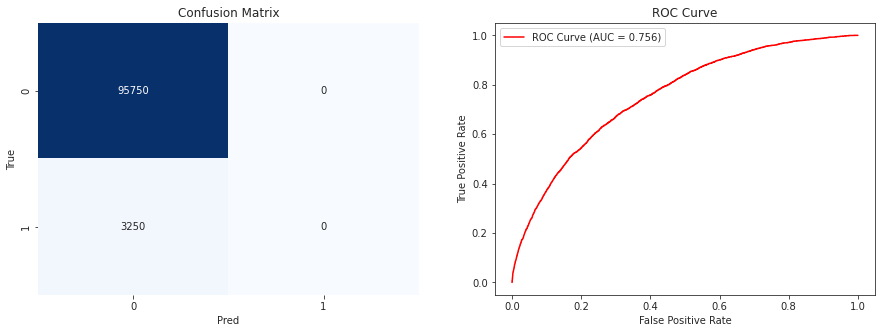

In [ ]:
loaded_model.eval()

true_labels = []
predictions = []

for batch in train_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels = batch

    with torch.no_grad():
        outputs = loaded_model(input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels=None)

    logits = outputs["logits"]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

    labels = labels.to("cpu").numpy()
    true_labels.append(labels)

train_y_true = []
train_y_pred = []
train_y_score = []

for i in range(len(predictions)):
    train_y_true.extend(list(true_labels[i]))
    train_y_pred.extend(((torch.sigmoid(torch.Tensor(predictions[i])) > 0.5) * 1).view(-1).tolist())
    train_y_score.extend(torch.sigmoid(torch.Tensor(predictions[i])).view(-1).tolist())

# Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_true=train_y_true, y_pred=train_y_pred)}\n")

# Classification report
print(metrics.classification_report(y_true=train_y_true, y_pred=train_y_pred))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Confusion matrix
cm = metrics.confusion_matrix(y_true=train_y_true, y_pred=train_y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

# ROC curve/AUC score
fpr, tpr, thresholds = metrics.roc_curve(y_true=train_y_true, y_score=train_y_score, pos_label=1)
auc_score = metrics.roc_auc_score(y_true=train_y_true, y_score=train_y_score)
ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend(loc="best")

Accuracy: 0.96976

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     48488
           1       0.00      0.00      0.00      1512

    accuracy                           0.97     50000
   macro avg       0.48      0.50      0.49     50000
weighted avg       0.94      0.97      0.95     50000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


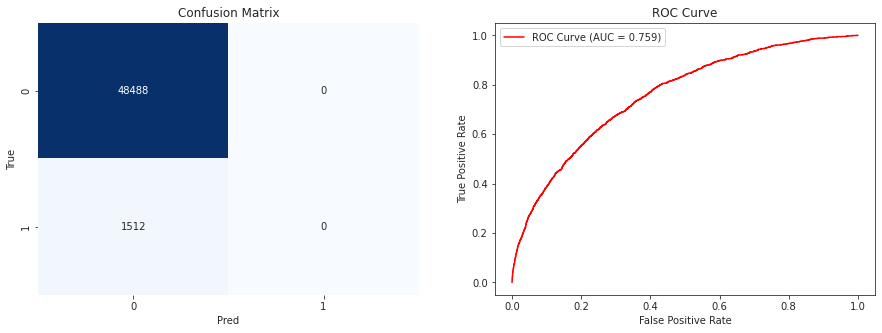

In [ ]:
loaded_model.eval()

true_labels = []
predictions = []

for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels = batch

    with torch.no_grad():
        outputs = loaded_model(input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels=None)

    logits = outputs["logits"]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

    labels = labels.to("cpu").numpy()
    true_labels.append(labels)

val_y_true = []
val_y_pred = []
val_y_score = []

for i in range(len(predictions)):
    val_y_true.extend(list(true_labels[i]))
    val_y_pred.extend(((torch.sigmoid(torch.Tensor(predictions[i])) > 0.5) * 1).view(-1).tolist())
    val_y_score.extend(torch.sigmoid(torch.Tensor(predictions[i])).view(-1).tolist())

# Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_true=val_y_true, y_pred=val_y_pred)}\n")

# Classification report
print(metrics.classification_report(y_true=val_y_true, y_pred=val_y_pred))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Confusion matrix
cm = metrics.confusion_matrix(y_true=val_y_true, y_pred=val_y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

# ROC curve/AUC score
fpr, tpr, thresholds = metrics.roc_curve(y_true=val_y_true, y_score=val_y_score, pos_label=1)
auc_score = metrics.roc_auc_score(y_true=val_y_true, y_score=val_y_score)
ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend(loc="best")

Accuracy: 0.96936

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     48468
           1       0.00      0.00      0.00      1532

    accuracy                           0.97     50000
   macro avg       0.48      0.50      0.49     50000
weighted avg       0.94      0.97      0.95     50000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


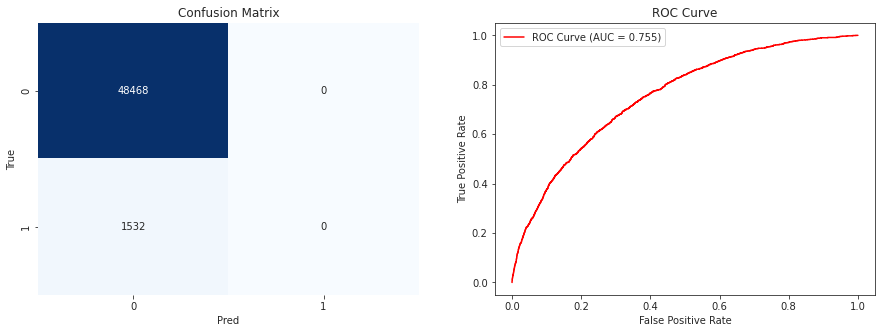

In [ ]:
loaded_model.eval()

true_labels = []
predictions = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels = batch

    with torch.no_grad():
        outputs = loaded_model(input_ids, attention_mask, _rel_pos_sentences, _len_sentence_logs, labels=None)

    logits = outputs["logits"]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

    labels = labels.to("cpu").numpy()
    true_labels.append(labels)

test_y_true = []
test_y_pred = []
test_y_score = []

for i in range(len(predictions)):
    test_y_true.extend(list(true_labels[i]))
    test_y_pred.extend(((torch.sigmoid(torch.Tensor(predictions[i])) > 0.5) * 1).view(-1).tolist())
    test_y_score.extend(torch.sigmoid(torch.Tensor(predictions[i])).view(-1).tolist())

# Accuracy
print(f"Accuracy: {metrics.accuracy_score(y_true=test_y_true, y_pred=test_y_pred)}\n")

# Classification report
print(metrics.classification_report(y_true=test_y_true, y_pred=test_y_pred))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Confusion matrix
cm = metrics.confusion_matrix(y_true=test_y_true, y_pred=test_y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

# ROC curve/AUC score
fpr, tpr, thresholds = metrics.roc_curve(y_true=test_y_true, y_score=test_y_score, pos_label=1)
auc_score = metrics.roc_auc_score(y_true=test_y_true, y_score=test_y_score)
ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend(loc="best")

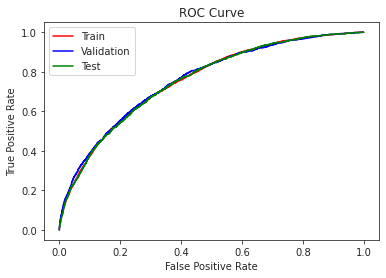

In [ ]:
# Combined ROC curve for train/val/test datasets

fpr, tpr, thresholds = metrics.roc_curve(y_true=train_y_true, y_score=train_y_score, pos_label=1)
plt.plot(fpr, tpr, color="red", label=f"Train")

fpr, tpr, thresholds = metrics.roc_curve(y_true=val_y_true, y_score=val_y_score, pos_label=1)
plt.plot(fpr, tpr, color="blue", label=f"Validation")

fpr, tpr, thresholds = metrics.roc_curve(y_true=test_y_true, y_score=test_y_score, pos_label=1)
plt.plot(fpr, tpr, color="green", label=f"Test")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")